In [124]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import numpy as np
import math
from datetime import datetime,timezone

from scipy import stats


In [102]:
# import functions_framework
# @functions_framework.http
# def load_v2_new_incident_ml_to_bq(request):

isTrainData=True
isExploreMode=True

schema_for_new_data=None
threshold_x_sd = 3  # 2x-4x
split_test=0.2
isShuffle=True  # if false ,it is not stratified

In [104]:
dt_imported=datetime.now(timezone.utc)

str_imported=dt_imported.strftime('%Y-%m-%d %H:%M:%S')
print(f"Imported DateTime: {str_imported}" )

# explore min and max import data
imported_to='2023-11-16' # beginning to 15Nov23
# SELECT max(imported_at) as max_date,min(imported_at) as min_date  FROM `pongthorn.SMartDW.incident` ;
# SELECT max(open_datetime) as max_date,min(open_datetime) as min_date  FROM `pongthorn.SMartDW.incident` ;


Imported DateTime: 2023-11-18 07:35:35


In [105]:
# projectId='smart-data-ml'
# credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# client = bigquery.Client(credentials=credentials, project=projectId)


projectId='pongthorn'
client = bigquery.Client(project=projectId)

dw_dataset_id="SMartDW"
dataset_id="SMartML"

dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

In [106]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

def loadDataFrameToBQ(table_id,dfx):
    try:
        if isTrainData:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_TRUNCATE",
            )
        else:
                   job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_APPEND",schema=schema_for_new_data
            )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"TrainData={isTrainData} : {len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

In [107]:
label='severity_id'
labelName='severity_name'

removeCols=['updated_at','imported_at']

# dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']
# numbericCols=['open_to_close_hour','response_to_resolved_hour']
# start_end_list=[ ['open_datetime','close_datetime'],['response_datetime','resolved_datetime']]

dateCols=['open_datetime','close_datetime']
numbericCols=['open_to_close_hour']
start_end_list=[ ['open_datetime','close_datetime']]


rangeCols=[]
cateCols=['sla','product_type','brand','service_type','incident_type']

# Create New Data Table

In [108]:
def get_table_schema(table_ml_id):
    schema=[]
    try:
        table=client.get_table(table_ml_id)  # Make an API request.
        schema=table.schema
        print("Table {} already exists.".format(table_ml_id))
    except Exception as ex:
        schema = [
        bigquery.SchemaField("id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("sla", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("product_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("brand", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("service_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("incident_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("open_to_close_hour", "FLOAT", mode="REQUIRED"),
        bigquery.SchemaField("range_open_to_close_hour", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("imported_at", "DATETIME", mode="REQUIRED")    
        ]

        table = bigquery.Table(table_ml_id,schema=schema)
        table.time_partitioning = bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,field="imported_at")


        table = client.create_table(table)  # Make an API request.
        print(
            "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
        )
    finally:
       print(f"Get Schema of {table_ml_id} as below.")    
       return schema
        

# Get Max Import Data From New Data

In [109]:
def get_last_imported_at(table_ml_id):

    sql_lastImport=f"SELECT max(imported_at) as last_imported from `{table_ml_id}` "

    print(sql_lastImport)

    job_lastImported=client.query(sql_lastImport)
    str_lastImported=None
    for row in job_lastImported:    
        if row.last_imported is not None: 
            str_lastImported=row.last_imported.strftime('%Y-%m-%d %H:%M:%S')
    print(f"Last Imported DateTime: {str_lastImported}" )

    if str_lastImported is not None:
      print("Start date from last loading")  
      start_date_query=str_lastImported
    else:
      start_date_query=imported_to  
      print("Init First loading") 
    return start_date_query    
    

# Explore and Transform Data

In [110]:
order_by=" order by id"
#order_by="order by imported_at

sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `{dw_table_id}` """

if isTrainData: # get from imported_to specified by you
    print(f"Build train/test data during imported date < {datetime.strptime(imported_to,'%Y-%m-%d')}")

    train_name='train2_incident'
    test_name='test2_incident'
    train_table_id=f"{projectId}.{dataset_id}.{train_name}"
    test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
    print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at< '{imported_to}'
    {order_by}
    
    """
    
else: # get from max update
    new_incident_name='new2_incident'    
    new_incident_table_id=f"{projectId}.{dataset_id}.{new_incident_name}"
    print(f"{new_incident_table_id}")
    
    # 1.get table and its schema
    schema_for_new_data=get_table_schema(new_incident_table_id)
    # print(schema_for_new_data)
    imported_to=get_last_imported_at(new_incident_table_id)  # get  start_date_query  from this method
    print(f"Load the most up-to-date new data from imported date >= {imported_to}")
    print(imported_to)
    
    
    sql_all=f""" {sql_all}
    WHERE imported_at>= '{imported_to}'
    {order_by}
    
    """

print(sql_all)


Build train/test data during imported date < 2023-11-16 00:00:00
TrainTable2=pongthorn.SMartML.train2_incident and TestTable2=pongthorn.SMartML.test2_incident
 
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `pongthorn.SMartDW.incident` 
    WHERE imported_at< '2023-11-16'
     order by id
    
    


In [114]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
print(f"Total origianal rows prior to perform data prep: {len(df_all)}")
no_original_rows=len(df_all)

if no_original_rows==0:
 print("No records from bigquery")  
 quit()
 # return "No new data imported to bigquery"   
else:
    
 df_all=df_all.drop_duplicates(subset=['id'],keep='last')   
 print(f"Import at :{df_all['imported_at'].min()} - {df_all['imported_at'].max()}")
 print(f"Open Date : {df_all['open_datetime'].min()} - {df_all['open_datetime'].max()}")   

print(df_all.info())
df_all[['id',"severity_id","severity_name","updated_at","imported_at"]].tail()

Load data from Bigquery
Total origianal rows prior to perform data prep: 4011
Import at :2023-07-15 23:59:00 - 2023-11-15 17:05:06.286635
Open Date : 2019-11-01 08:30:00 - 2023-11-15 09:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3813 entries, 0 to 4010
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              3813 non-null   Int64         
 1   severity_id     3813 non-null   Int64         
 2   severity_name   3813 non-null   object        
 3   sla             3813 non-null   object        
 4   product_type    3813 non-null   object        
 5   brand           3813 non-null   object        
 6   service_type    3813 non-null   object        
 7   incident_type   3813 non-null   object        
 8   open_datetime   3813 non-null   datetime64[ns]
 9   close_datetime  3813 non-null   datetime64[ns]
 10  updated_at      3813 non-null   datetime64[ns]
 11  imported_at     3813

,id,severity_id,severity_name,updated_at,imported_at
4006,4012,3,Minor,2023-11-15 11:41:38,2023-11-15 17:05:06.286635
4007,4013,4,Cosmetic,2023-11-15 11:47:14,2023-11-15 17:05:06.286635
4008,4014,3,Minor,2023-11-15 12:44:08,2023-11-15 17:05:06.286635
4009,4015,3,Minor,2023-11-15 14:06:07,2023-11-15 17:05:06.286635
4010,4016,4,Cosmetic,2023-11-15 15:09:16,2023-11-15 17:05:06.286635


# Transform and enrich data

# Manage Numberic Cols
### 1-Find Time Inverval
### 2-Remove outlier on Time Interval to service
### 3-Find any rows  contain zero time period
### 4-Create range from time-interval (best,good,moderate,bad,worst)

# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

we can convert hour to range   
* (0, 24] =by 1 day =best
* (24, 168] =  1day -1 week  =good
* (168, 360]=  1week- 15 days(half a month) =fair
* (360, 720]= 15 dasy-1 month =bad
* (720, 2349]=1 month-1 Q =worst

open_to_close_hour ,response_to_resolved_hour , Mostly  we can complate by 1 day (0, 24]
there are few cases that take long to close incident (360, 720]   15 day to  1month

In [115]:
print("Manage Numberic Cols")
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  

# df_all.tail()

Manage Numberic Cols


# Remove oulier  and delete zero hour training data

In [116]:
if isTrainData :
    print("Remove oulier  and delete zero hour training data")
    for col in  xScoreDiffHourCols:
      df_all=df_all.query(f"{col}<@threshold_x_sd")


    allRows=df_all.shape[0]
    for col in numbericCols:
        zeroRows=len(df_all.query(f"{col}==0"))
        pctZeroHour=round(zeroRows/allRows*100,1)
        print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
        df_all=df_all.query(f'{col}!=0')

Remove oulier  and delete zero hour training data
No. 0-hour row on open_to_close_hour = 1(0.0 %)


# Apply Service Level

In [117]:
def service_hour_range(x_hour):
    if x_hour>0 and x_hour<=24:
      return "soonest"
    elif x_hour>25 and x_hour<=168:
      return "soon"
    elif x_hour>168 and x_hour<=360:
      return "fair"
    elif x_hour>360 and x_hour<=720:
      return "late"
    else:
      return "latest"

for col in numbericCols:
    range_col=f"range_{col}"
    rangeCols.append(range_col)
    df_all[range_col]=df_all[col].apply(service_hour_range)

# Final TRansform

In [118]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")
df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

df_all[['id','severity_id']] =df_all[['id','severity_id']].astype('int64')

if isTrainData==False:
    df_all['imported_at']=dt_imported

print(df_all.info())


print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable
# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

df_all.tail(30)

Remove ['updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'zscore_open_to_close_hour', 'open_to_close']
% remove data 6.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 4010
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3755 non-null   int64  
 1   severity_id               3755 non-null   int64  
 2   severity_name             3755 non-null   object 
 3   sla                       3755 non-null   object 
 4   product_type              3755 non-null   object 
 5   brand                     3755 non-null   object 
 6   service_type              3755 non-null   object 
 7   incident_type             3755 non-null   object 
 8   open_to_close_hour        3755 non-null   float64
 9   range_open_to_close_hour  3755 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 322.7+ KB
None
pct removed data =6.38244826

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,range_open_to_close_hour
3981,3973,3,Minor,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,51.500000,soon
3982,3974,4,Cosmetic,24x7 4Hrs Resolution Time,Server,HPE,Request,Configuration Change,93.883333,soon
3983,3975,1,Critical,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,24.500000,latest
3984,3976,1,Critical,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,28.000000,soon
3985,3977,1,Critical,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,25.250000,soon
3986,3978,1,Critical,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,2.000000,soonest
3987,3980,1,Critical,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,2228.000000,latest
3988,3981,3,Minor,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,16.400000,soonest
3989,3982,3,Minor,24x7 4Hrs Response Time,Software,Red Hat,Incident,General Incident,24.000000,soonest
3990,3983,2,Major,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,7.200000,soonest


In [119]:
# # https://www.geeksforgeeks.org/pandas-cut-method-in-python/
# def explore_ranges_numberic_val(col,rangeList):
#     print(col)
#     rangeList.sort()
#     return pd.cut(df_all[col],rangeList, right=True).value_counts()
# range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
# print(explore_ranges_numberic_val('open_to_close_hour',range1))
# print("=======================================================")

# range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
# print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
# print("=======================================================")



# Plot Numeric  and Category columns

Plot Numeric  and Category columns


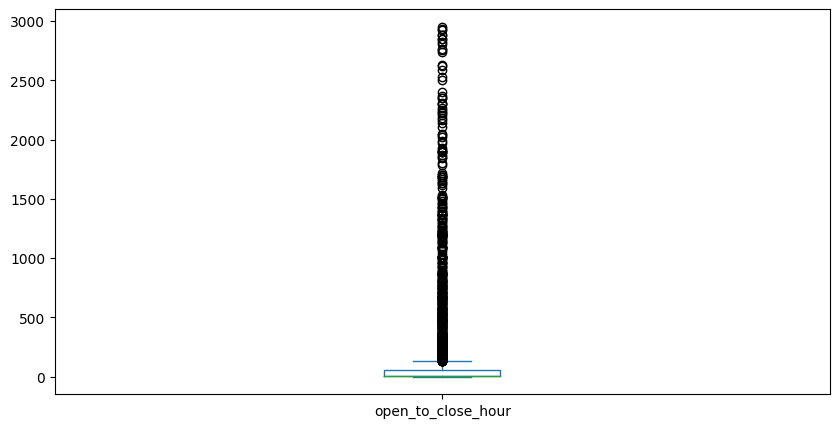

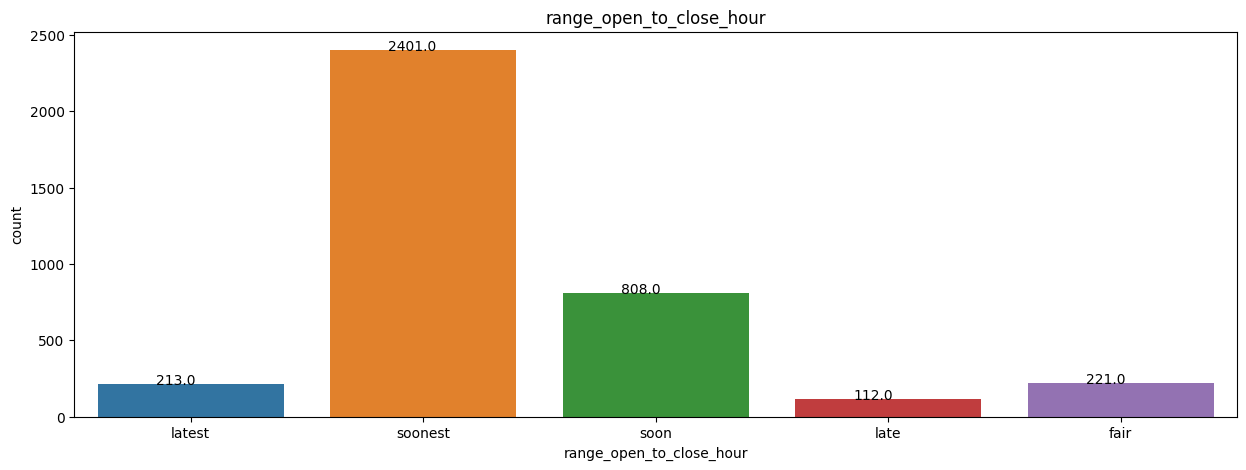

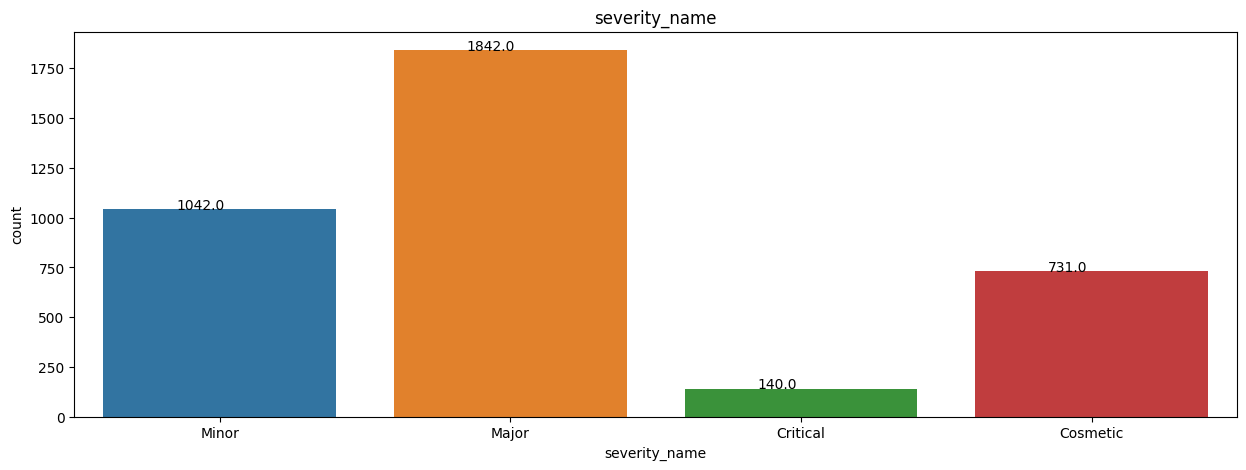

In [120]:
# comment on google cloud
if isExploreMode:
    print("Plot Numeric  and Category columns")
    import seaborn as sns
    import matplotlib.pyplot  as plt

if isExploreMode:
    df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
    plt.show()
    
if isExploreMode:
    barCols=rangeCols+["severity_name"]
    for col in barCols:
        fig , ax = plt.subplots(figsize=(15,5))
        ax =sns.countplot(x=col, data=df_all,)
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        plt.title(col)
        plt.show()

# Build Label and Split into Train/Test DataSet

In [121]:
if isTrainData:
    
    print(" Build Label and Split into Train/Test DataSet")
    from sklearn.model_selection import train_test_split
    
    # create label
    map_severity_to_class={4:0,3: 1, 2: 2, 1: 3}
    print(f"Map severity id to LabelCode: {str(map_severity_to_class)}")

    df_all['label_multi_severity'] =df_all['severity_id'].map(map_severity_to_class) 
    def map_4to2_serverity(severity_id):
        if severity_id==1 or severity_id==2:
           return 1
        else:
           return 0 
    df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

    print( list(df_all['label_multi_severity'].unique()))
    print(df_all['label_binary_severity'].unique())

    #Split data into 2 dataset to BQ
    len_all=len(df_all)
    print(f"All Data = {len_all}")
    
# shufflebool, default=True
# Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# stratifyarray-like, default=None
# If not None, data is split in a stratified fashion, using this as the class labels. Read more in the User Guide.

# Split the 80% of total as train
# The remaining  will be splited equally 50% for valuation and the rest of later part is test
    train, test = train_test_split(df_all,test_size=split_test,random_state=1000,shuffle=isShuffle) 

    len_all=len(df_all)
    len_train=len(train)

    len_test=len(test)
    print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
    print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

    print(train.tail())

    loadDataFrameToBQ(train_table_id,train)
    loadDataFrameToBQ(test_tabel_id,test)  
    
    # if isExploreMode:
    #     train.to_csv(f"data/{train_name}.csv",index=False)
    #     test.to_csv(f"data/{test_name}.csv",index=False)
        
else:
    print(" Build Unseen DataSet")
    
    loadDataFrameToBQ(new_incident_table_id,df_all)
    

 Build Label and Split into Train/Test DataSet
Map severity id to LabelCode: {4: 0, 3: 1, 2: 2, 1: 3}
[1, 2, 3, 0]
[0 1]
All Data = 3755
3004 =train examples (80.0%)
751 =test examples (20.0%)
        id  severity_id severity_name                        sla product_type  \
2482  2556            3         Minor  24x7 6Hrs Resolution Time     Software   
3546  3517            2         Major  24x7 4Hrs Resolution Time     Software   
2187  2262            2         Major  24x7 4Hrs Resolution Time      Storage   
621    663            3         Minor  24x7 6Hrs Resolution Time     Software   
1492  1565            4      Cosmetic    24x7 4Hrs Response Time     Software   

           brand service_type            incident_type  open_to_close_hour  \
2482  CIMCO-CMMS     Incident         General Incident            1.416667   
3546      VMWare     Incident                 Software            1.516667   
2187         HPE     Incident  Network Adapter Failure          583.150000   
621     

In [122]:
# return "Imported data to bigquery successfully"